In [7]:
import numpy as np
import torch
import torchaudio
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import os

In [8]:
df = pd.DataFrame()
df['filename'] = pd.Series(os.listdir('../data/Crema'))
df['category'] = df['filename'].str.extract(r'\d+_[A-Z]{3}_([A-Z]{3})_[A-Z]+.wav')

df.head()

,filename,category
0,1028_ITS_ANG_XX.wav,ANG
1,1065_WSI_ANG_XX.wav,ANG
2,1014_IOM_ANG_XX.wav,ANG
3,1034_IWL_HAP_XX.wav,HAP
4,1005_DFA_HAP_XX.wav,HAP


In [22]:
def wav_to_numpy(filename):
    path = os.path.join('..', 'data', 'Crema', filename)
    waveform, sample_rate = torchaudio.load(path)
    waveform = waveform.numpy()[0] 
    
    return waveform, sample_rate

In [23]:
def plot_fft(filename):
    waveform, sample_rate = wav_to_numpy(filename)
    
    fft = np.fft.fft(waveform, norm='ortho')
    fs_shifted = np.linspace(-len(fft) // 2, len(fft) // 2, len(fft)) * sample_rate / len(fft)

    plt.plot(fs_shifted, np.abs(np.fft.fftshift(fft)))
    plt.show() 

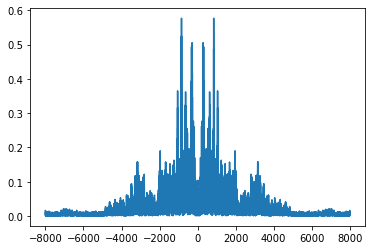

In [24]:
plot_fft('1028_ITS_ANG_XX.wav')

In [34]:
ffts = []
for index, row in df.iterrows():
    waveform, _ = wav_to_numpy(row.filename)
    fft = np.fft.fft(waveform, norm='ortho')
    
    ffts.append(np.abs(np.fft.fftshift(fft))[len(fft) // 2 - 10000: len(fft) // 2 + 10000])

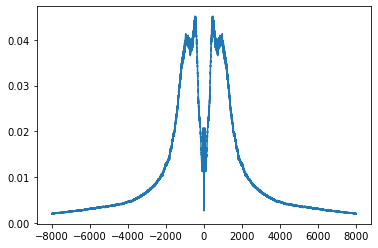

In [42]:
fft_avg = np.median(np.array(ffts), axis=0)

fs_shifted = np.linspace(-len(fft_avg) // 2, len(fft_avg) // 2, len(fft_avg)) * 16000 / len(fft_avg)

plt.plot(fs_shifted, fft_avg)

In [103]:
max_freq = 150
freq_df = pd.DataFrame(columns=[f'freq{i}' for i in range(1, max_freq+1)])
for index, row in df.iterrows():
    waveform, _ = wav_to_numpy(row.filename)
    fft = np.fft.fft(waveform, norm='ortho')
    fs_shifted = np.linspace(-len(fft) // 2, len(fft) // 2, len(fft)) * 16000 / len(fft)
    
    shifted = np.abs(np.fft.fftshift(fft))
    
    relev_freqs = fs_shifted[len(fft)//2: len(fft) // 2 + max_freq]
    relev_ampls = shifted[len(fft)//2: len(fft) // 2 + max_freq]
    
    sorted_freqs = [freq for _, freq in sorted(zip(relev_ampls, relev_freqs))]
    freq_df.loc[len(freq_df.index)] = dict(zip(cols, sorted_freqs))

freq_df['category'] = df['category']
freq_df.head()

/tmp/ipykernel_122/3510147804.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  freq_df['category'] = df['category']


,freq1,freq2,freq3,freq4,freq5,freq6,freq7,freq8,freq9,freq10,...,freq142,freq143,freq144,freq145,freq146,freq147,freq148,freq149,freq150,category
0,34.966010,37.556084,39.776148,2.405073,47.546371,34.595999,0.185010,2.775084,49.396424,0.925031,...,20.535595,13.505393,25.715744,22.015637,18.685541,20.165584,19.795573,20.905605,19.425563,ANG
1,34.097085,1.954616,4.560762,53.643181,1.085900,11.944842,1.520258,38.875019,62.764693,46.693458,...,14.116631,10.641769,9.773054,21.500712,13.682273,10.207412,22.369427,13.247916,21.935069,ANG
2,38.686497,39.298141,2.599491,40.827252,9.633399,44.497117,32.264233,34.099166,0.152914,24.618681,...,21.254638,19.725528,22.783748,13.609086,26.147791,20.948816,19.113883,21.560460,21.866282,ANG
3,5.556374,3.535874,4.882874,2.188875,1.852125,4.209374,45.292867,1.178625,0.841875,12.964873,...,21.383621,26.098121,29.465620,23.067371,30.139120,22.057121,43.945867,20.036622,13.975123,HAP
4,54.297322,3.308439,2.919211,42.231250,4.476123,18.488335,2.140755,24.715985,11.093001,5.643808,...,43.398934,43.009706,44.955847,53.518865,48.069672,27.051354,57.411147,55.854234,56.632690,HAP


In [104]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [105]:
X = freq_df.drop(columns=['category'])
y = freq_df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

svm = SVC(C=1, kernel='rbf')
svm.fit(X_train, y_train)

SVC(C=1)

In [106]:
train_preds = svm.predict(X_train)
confusion_matrix(y_train, train_preds)

array([[686, 122,  40,  39,  29,  71],
       [ 48, 678,  42,  72,  22,  57],
       [ 50, 135, 643,  40,  26,  62],
       [ 59, 106,  44, 672,  18,  62],
       [ 35, 104,  48,  48, 511,  66],
       [ 41, 156,  46,  42,  21, 640]])

In [107]:
print(classification_report(y_train, preds))

              precision    recall  f1-score   support

         ANG       0.44      0.41      0.42       987
         DIS       0.36      0.45      0.40       919
         FEA       0.38      0.36      0.37       956
         HAP       0.37      0.52      0.43       961
         NEU       0.42      0.24      0.30       812
         SAD       0.39      0.33      0.36       946

    accuracy                           0.39      5581
   macro avg       0.39      0.39      0.38      5581
weighted avg       0.39      0.39      0.38      5581



In [108]:
test_preds = svm.predict(X_test)
confusion_matrix(y_test, test_preds)

array([[ 89,  57,  39,  48,  23,  28],
       [ 42, 136,  38,  59,  27,  50],
       [ 49,  59,  38,  88,  35,  46],
       [ 48,  44,  36, 120,  28,  34],
       [ 22,  45,  44,  80,  39,  45],
       [ 33,  76,  46,  71,  46,  53]])

In [109]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

         ANG       0.31      0.31      0.31       284
         DIS       0.33      0.39      0.35       352
         FEA       0.16      0.12      0.14       315
         HAP       0.26      0.39      0.31       310
         NEU       0.20      0.14      0.16       275
         SAD       0.21      0.16      0.18       325

    accuracy                           0.26      1861
   macro avg       0.24      0.25      0.24      1861
weighted avg       0.24      0.26      0.25      1861



In [110]:
train_f1s = []
test_f1s = []
train_accs = []
test_accs = []

Cs = np.array([0.0001, 0.01, 0.1, 1, 10, 100, 1000])
for c in Cs:
    svm = SVC(C=c, kernel='rbf')
    svm.fit(X_train, y_train)
    
    train_preds = svm.predict(X_train)
    test_preds = svm.predict(X_test)
    
    train_f1s.append(f1_score(y_train, train_preds, average='macro'))
    test_f1s.append(f1_score(y_test, test_preds, average='macro'))
    
    train_accs.append(np.mean(train_preds == y_train))
    test_accs.append(np.mean(test_preds == y_test))

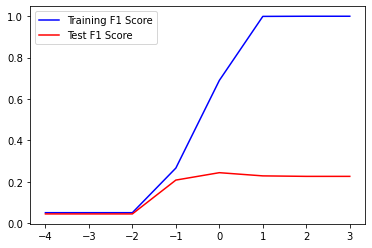

In [111]:
plt.plot(np.log10(Cs), train_f1s, color='blue', label='Training F1 Score')
plt.plot(np.log10(Cs), test_f1s, color='red', label='Test F1 Score')
plt.legend()
plt.show()

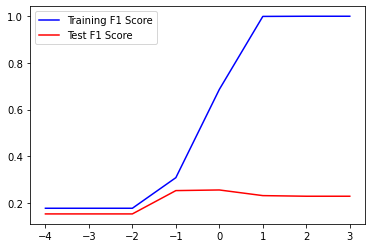

In [112]:
plt.plot(np.log10(Cs), train_accs, color='blue', label='Training F1 Score')
plt.plot(np.log10(Cs), test_accs, color='red', label='Test F1 Score')
plt.legend()
plt.show()